In [66]:
import pandas as pd 
import numpy as np 
import pickle 
import torch as t
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import seaborn as sns
import pandas as pd
import einops
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde
from sklearn.base import clone
import os
from datetime import datetime
import torch as t
from pathlib import Path

In [106]:
import matplotlib.pyplot as plt
import numpy as np

def plot_lines(data_list, labels=None, title="Accuracy Plot (Residual)", 
                          xlabel="Layer", ylabel="Probe Accuracy", figsize=(12, 7),
                          linewidth=1.5, alpha=0.9, legend_cols=2,
                          legend_loc='lower right', dpi=300, grid_alpha=0.25,
                          font_size=13, title_size=15, save_path=None,
                          bbox_to_anchor=None):
    """
    Creates publication-ready plots with model family color grouping.
    
    Args:
        data_list (list): List of arrays/lists with y-values to plot
        labels (list): Labels for each line (model names)
        title (str): Plot title
        xlabel (str): X-axis label
        ylabel (str): Y-axis label
        figsize (tuple): Figure size (width, height)
        linewidth (float): Line width
        alpha (float): Line transparency (0-1)
        legend_cols (int): Number of columns in legend
        legend_loc (str): Legend location
        dpi (int): Resolution for saved figure
        grid_alpha (float): Grid transparency
        font_size (int): General font size
        title_size (int): Title font size
        save_path (str, optional): Path to save figure
        bbox_to_anchor (tuple, optional): Legend position override (use None for standard positioning)
    """
    
    # Set publication-quality style
    plt.rcParams.update({
        'font.size': font_size,
        'axes.labelsize': font_size + 1,
        'axes.titlesize': title_size,
        'xtick.labelsize': font_size,
        'ytick.labelsize': font_size,
        'legend.fontsize': font_size - 1,
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'DejaVu Sans'],
        'axes.linewidth': 1.3,
        'grid.linewidth': 0.8,
        'lines.linewidth': linewidth,
        'xtick.major.width': 1.3,
        'ytick.major.width': 1.3,
        'xtick.major.size': 5,
        'ytick.major.size': 5,
    })
    
    # Define model family colors and line styles with better visual distinction
    model_families = {
        'gpt': {'color': '#0173B2', 'style': '-', 'marker': 'o'},  # Blue
        'gpt-j': {'color': '#DE8F05', 'style': '-', 'marker': 's'},  # Orange
        'llama': {'color': '#029E73', 'style': '-', 'marker': 'o'},  # Green
        'llama_instruct': {'color': '#029E73', 'style': '--', 'marker': 's'},  # Green dashed
        'llama_medium': {'color': '#029E73', 'style': ':', 'marker': '^'},  # Green dotted
        'gemma': {'color': '#CC3311', 'style': '-', 'marker': 'o'},  # Red
        'gemma_instruct': {'color': '#CC3311', 'style': '--', 'marker': 's'},  # Red dashed
        'pythia': {'color': '#9467BD', 'style': '-', 'marker': 'o'},  # Purple
        'pythia_deduped': {'color': '#9467BD', 'style': '--', 'marker': 's'},  # Purple dashed
        'yi': {'color': '#865A3C', 'style': '-', 'marker': 'o'},  # Brown
        'yi_instruct': {'color': '#865A3C', 'style': '--', 'marker': 's'},  # Brown dashed
    }
    
    fig, ax = plt.subplots(figsize=figsize, dpi=100)
    
    # Plot each line with family-specific styling
    for i, data in enumerate(data_list):
        label = labels[i] if labels is not None else f"Line {i+1}"
        
        # Get styling for this model
        style_info = model_families.get(label, {'color': '#7f7f7f', 'style': '-', 'marker': 'o'})
        
        # Smart marker spacing based on data length
        marker_spacing = max(len(data) // 8, 1) if len(data) > 15 else 1
        
        ax.plot(data, 
               color=style_info['color'],
               linestyle=style_info['style'],
               linewidth=linewidth,
               alpha=alpha,
               label=label.replace('_', ' ').title(),  # Prettier labels
               marker=style_info['marker'],
               markersize=5,
               markevery=marker_spacing,
               markeredgewidth=0.5,
               markeredgecolor='white')
    
    # Styling
    ax.set_title(title, pad=20, fontweight='600')
    ax.set_xlabel(xlabel, fontweight='600', labelpad=10)
    ax.set_ylabel(ylabel, fontweight='600', labelpad=10)
    
    # Enhanced grid
    ax.grid(True, alpha=grid_alpha, linestyle='-', linewidth=0.8, color='gray')
    ax.set_axisbelow(True)
    
    # Set background color for better contrast
    ax.set_facecolor('#FAFAFA')
    fig.patch.set_facecolor('white')
    
    legend_kwargs = {
        'loc': legend_loc,
        'ncol': 1,  # Single column for full vertical layout
        'frameon': True,
        'fancybox': False,
        'shadow': False,
        'framealpha': 0.5,
        'edgecolor': '#CCCCCC',
        'borderpad': 1.0,
        'labelspacing': 0.6,  # Tighter spacing for vertical layout
        'handlelength': 2.5
    }
    
    # Add bbox_to_anchor only if specified
    if bbox_to_anchor is not None:
        legend_kwargs['bbox_to_anchor'] = bbox_to_anchor
    
    legend = ax.legend(**legend_kwargs)
    
    # Make legend lines thicker and add border
    legend.get_frame().set_linewidth(1.2)
    for line in legend.get_lines():
        line.set_linewidth(3.0)
    
    # Add subtle border to plot
    for spine in ax.spines.values():
        spine.set_edgecolor('#CCCCCC')
        spine.set_linewidth(1.3)
    
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
        print(f"Figure saved to: {save_path}")
    
    plt.show()
    
    # Reset to defaults
    plt.rcParams.update(plt.rcParamsDefault)

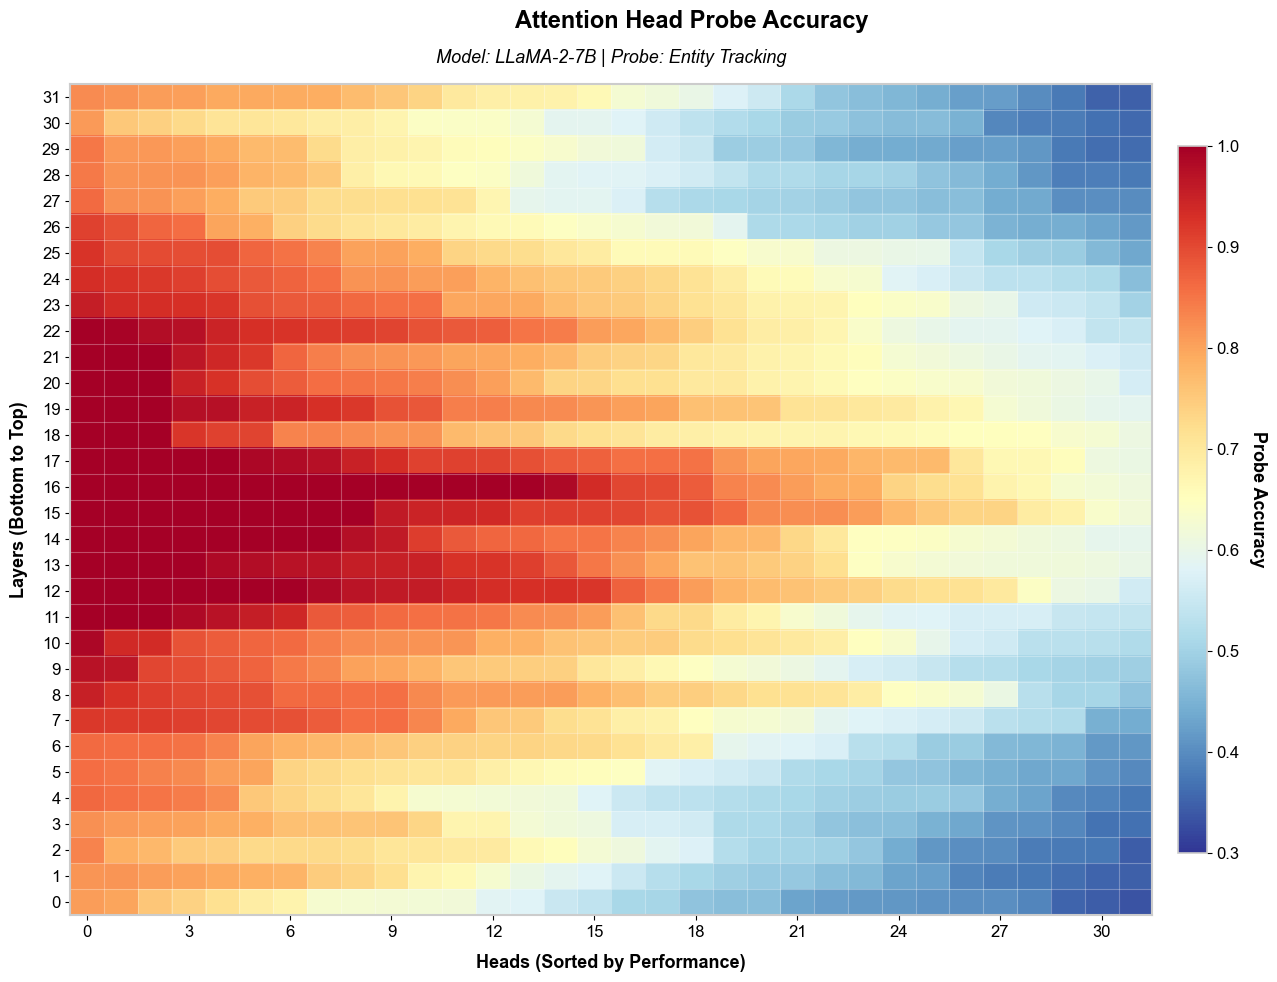

In [126]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import numpy as np

def plot_heat(accuracies, title="DummyTitle", x_axis="Heads (Sorted)",
              y_axis="Layers (Bottom-Up)", model="Model", probe="Probe",
              figsize=(14, 10), cmap="RdYlBu_r", vmin=None, vmax=None,
              annot=False, font_size=12, cbar_label="Accuracy",
              save_path=None, dpi=300, interpolation='none'):
    """
    Creates publication-ready heatmaps with sorted accuracy values.
    
    Args:
        accuracies (array): 2D array of accuracy values (layers × heads)
        title (str): Main title
        x_axis (str): X-axis label
        y_axis (str): Y-axis label
        model (str): Model name for subtitle
        probe (str): Probe name for subtitle
        figsize (tuple): Figure size (width, height)
        cmap (str): Colormap options:
                   - 'RdYlBu_r': Red-Yellow-Blue (reversed, blue=high)
                   - 'coolwarm': Blue-White-Red
                   - 'PuOr_r': Purple-Orange (reversed, orange=high)
                   - 'RdBu_r': Red-Blue (reversed, blue=high)
                   - 'viridis', 'plasma': Perceptually uniform
        vmin (float, optional): Minimum value for colorbar
        vmax (float, optional): Maximum value for colorbar
        annot (bool): Whether to annotate cells with values
        font_size (int): Base font size
        cbar_label (str): Colorbar label
        save_path (str, optional): Path to save figure
        dpi (int): Resolution for saved figure
        interpolation (str): Interpolation method ('none', 'bilinear', 'gaussian')
                            'none' keeps sharp boundaries (recommended)
                            'bilinear' smooths slightly, 'gaussian' very smooth
    """
    
    # Set publication style
    plt.rcParams.update({
        'font.size': font_size,
        'axes.labelsize': font_size + 1,
        'axes.titlesize': font_size + 3,
        'xtick.labelsize': font_size,
        'ytick.labelsize': font_size,
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'DejaVu Sans'],
    })
    
    # Process data
    accuracies = np.array(accuracies)
    sorted_accuracies = np.sort(accuracies, axis=1)[:, ::-1]
    sorted_accuracies = sorted_accuracies[::-1, :]
    
    # Set normalization
    if vmin is None:
        vmin = sorted_accuracies.min()
    if vmax is None:
        vmax = max(sorted_accuracies.max(), 0.75)
    
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize, dpi=100)
    
    # Create heatmap with sharp boundaries
    im = ax.imshow(sorted_accuracies, 
                   cmap=cmap, 
                   norm=norm, 
                   aspect='auto',
                   interpolation=interpolation)
    
    # Add colorbar with better styling
    cbar = plt.colorbar(im, ax=ax, shrink=0.85, aspect=25, pad=0.02)
    cbar.set_label(cbar_label, rotation=270, labelpad=20, 
                   fontsize=font_size + 1, fontweight='600')
    cbar.ax.tick_params(labelsize=font_size)
    cbar.outline.set_linewidth(1.2)
    cbar.outline.set_edgecolor('#CCCCCC')
    
    # Optionally annotate cells
    if annot:
        for i in range(sorted_accuracies.shape[0]):
            for j in range(sorted_accuracies.shape[1]):
                text_color = 'white' if sorted_accuracies[i, j] < (vmin + vmax) / 2 else 'black'
                ax.text(j, i, f'{sorted_accuracies[i, j]:.2f}',
                       ha='center', va='center', 
                       color=text_color, fontsize=font_size - 2)
    
    # Set ticks and labels
    num_layers = sorted_accuracies.shape[0]
    num_heads = sorted_accuracies.shape[1]
    
    ax.set_yticks(np.arange(num_layers))
    ax.set_yticklabels(np.arange(num_layers - 1, -1, -1))
    
    # Show x-ticks at regular intervals for better readability
    x_tick_interval = max(1, num_heads // 10)
    ax.set_xticks(np.arange(0, num_heads, x_tick_interval))
    ax.set_xticklabels(np.arange(0, num_heads, x_tick_interval))
    
    # Labels and titles
    ax.set_xlabel(x_axis, fontsize=font_size + 1, fontweight='600', labelpad=10)
    ax.set_ylabel(y_axis, fontsize=font_size + 1, fontweight='600', labelpad=10)
    
    # Two-line title
    fig.suptitle(title, fontsize=font_size + 5, fontweight='600', y=0.98)
    ax.set_title(f"Model: {model} | Probe: {probe}", 
                fontsize=font_size + 1, pad=15, style='italic')
    
    # Visible gridlines for structure
    ax.set_xticks(np.arange(num_heads + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(num_layers + 1) - 0.5, minor=True)
    ax.grid(which="minor", color="white", linestyle='-', linewidth=0.8, alpha=0.3)
    ax.tick_params(which="minor", size=0)
    
    # Style borders
    for spine in ax.spines.values():
        spine.set_edgecolor('#CCCCCC')
        spine.set_linewidth(1.5)
    
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
        print(f"Figure saved to: {save_path}")
    
    plt.show()
    
    # Reset defaults
    plt.rcParams.update(plt.rcParamsDefault)


# Example usage
if __name__ == "__main__":
    np.random.seed(42)
    
    # Generate sample data (32 layers × 32 heads)
    num_layers = 32
    num_heads = 32
    accuracies = np.random.rand(num_layers, num_heads) * 0.5 + 0.3
    
    # Add some structure (better performance in middle layers)
    for i in range(num_layers):
        layer_boost = 0.3 * np.exp(-((i - num_layers/2) ** 2) / 100)
        accuracies[i, :] += layer_boost
    
    # Create heatmap
    plot_heat(
        accuracies,
        title="Attention Head Probe Accuracy",
        x_axis="Heads (Sorted by Performance)",
        y_axis="Layers (Bottom to Top)",
        model="LLaMA-2-7B",
        probe="Entity Tracking",
        figsize=(14, 10),
        cmap="RdYlBu_r",  # Options: 'RdYlBu_r', 'coolwarm', 'PuOr_r', 'RdBu_r', 'viridis'
        vmin=0.3,
        vmax=1.0,
        annot=False,
        interpolation='none',  # 'none' for crisp cells, 'bilinear' for smooth
        cbar_label="Probe Accuracy",
        # save_path='heatmap.pdf'  # Uncomment to save
    )

# ACCURACY

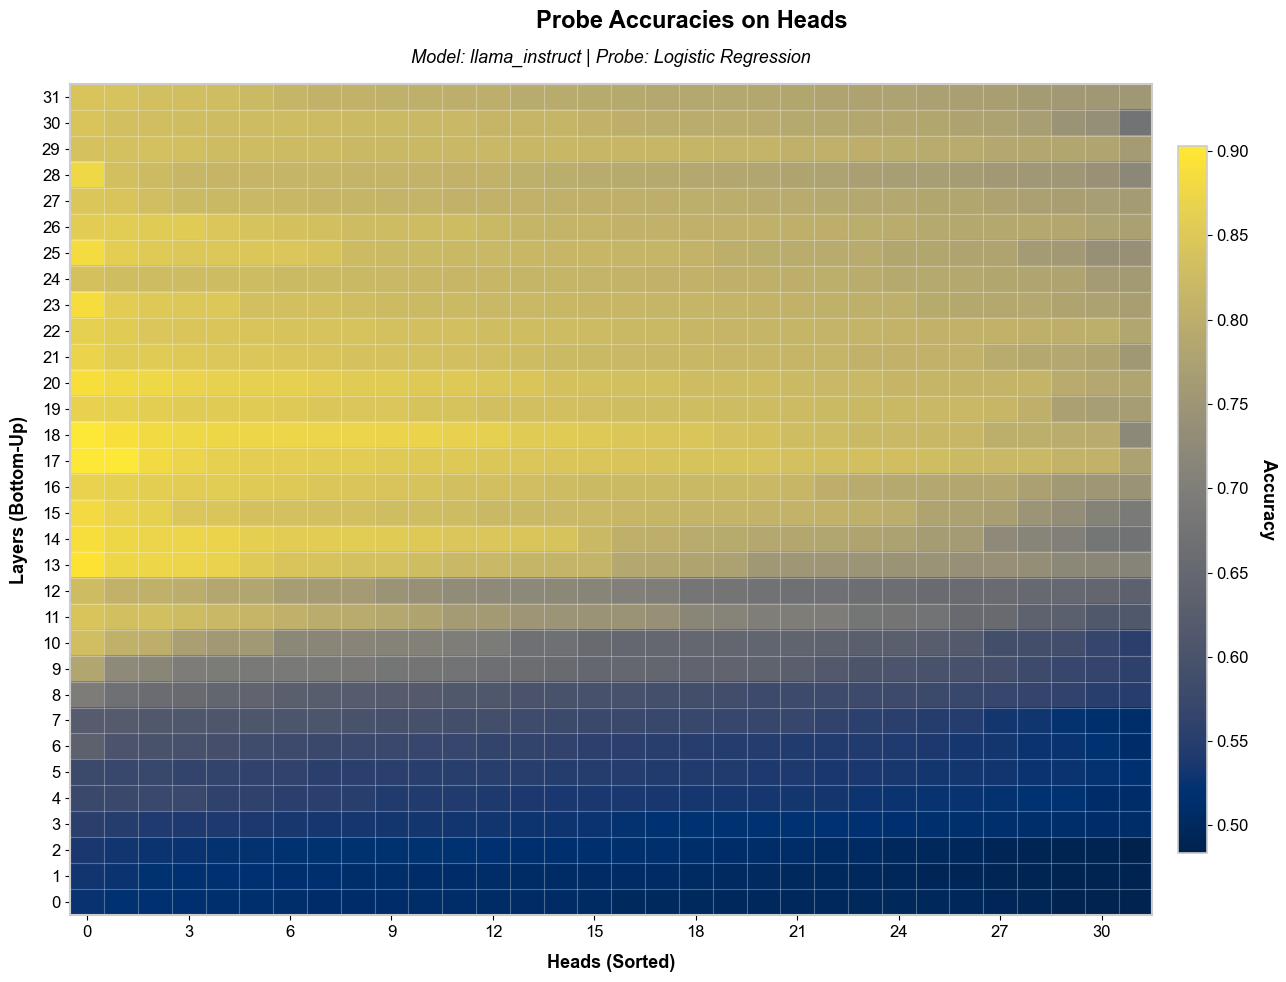

In [151]:
PATH = Path('results_to_plot')
data_residual_full = []

models = ['gpt', 'gpt-j', 'llama', 'llama_instruct', 'gemma', 'gemma_instruct', 'llama_medium', 'pythia', 'pythia_instruct', 'yi', 'yi_instruct']

for model in models:
    data_residual = t.load(PATH / model / 'ACCURACY' / 'accuracies_residual')
    data_residual_full.append(data_residual)
models = ['gpt', 'gpt-j', 'llama', 'llama_instruct', 'gemma', 'gemma_instruct', 'llama_medium', 'pythia', 'pythia_deduped', 'yi', 'yi_instruct']

model = 'llama_instruct'
data_heads = t.load(PATH / model / 'ACCURACY' / 'accuracies_heads')
data_residual = t.load(PATH / model / 'ACCURACY' / 'accuracies_residual')
# plot_lines(data_residual_full, labels=models)
plot_heat(data_heads, title='Probe Accuracies on Heads', model=model, probe='Logistic Regression', interpolation='antialiased', cmap='cividis')

# USE

In [31]:
import os

model = 'llama_instruct'
folder = (PATH / model / 'USE')


for filename in os.listdir(folder):
    if filename.endswith("heads") or filename.endswith("residual"): 
        continue
    else:
        file_path = os.path.join(folder, filename)
        data = t.load(file_path)
        print(f"{filename}: {data}")

intervention_sweep_heads_20251223_105127: [[-0.44238389]]
intervention_sweep_heads_20251223_105850: [[-9.93016379e-05]]
intervention_sweep_heads_20251223_110808: [[-0.00102712]]
intervention_sweep_heads_20251223_115412: [[ 0.5723845   0.55554388  0.53703438  0.51644046  0.49441321]
 [ 0.15242578 -0.73705094 -0.97353039 -0.98099307 -0.97342858]
 [-0.06147312 -0.95842839 -0.96665825 -0.89994219 -0.75538596]
 [-0.16367309 -0.94521045 -0.80144698 -0.31094074 -0.04810906]
 [-0.51968346 -0.95755797 -0.7492332  -0.15304286 -0.00465545]]
intervention_sweep_heads_20251223_150223: [[-0.80890947]]
intervention_sweep_heads_20251223_153941: [[-0.77893561 -0.76634012 -0.75491346 -0.74167699 -0.71978331]
 [-0.80913743 -0.79556886 -0.78416586 -0.77186658 -0.75133805]
 [-0.83655984 -0.81805401 -0.80399803 -0.78882317 -0.76533596]
 [-0.8377742  -0.81853672 -0.804344   -0.7889264  -0.76554508]]
intervention_sweep_heads_20251223_195525: [[-1.67729104e-01 -1.64068699e-01 -1.59602490e-01 -1.54604988e-01
  -

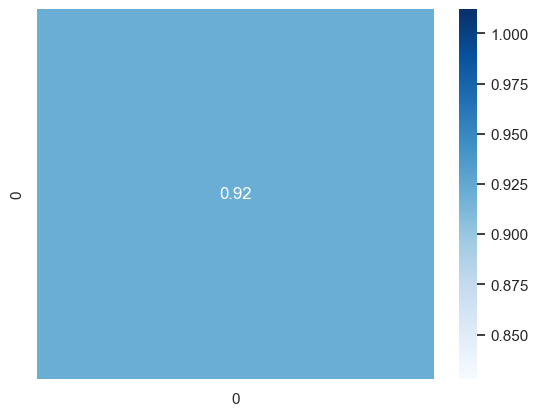

In [32]:
INTERVENTION_TYPE = 'residual'
model = 'gpt-j'
data_sweep = t.load(PATH / model / 'USE' / f"intervention_sweep_{INTERVENTION_TYPE}")
n_rows, n_cols = data_sweep.shape
fig, ax = plt.subplots()

# Set x and y ticks manually
ax.set_xticks(np.arange(n_cols) + 0.5)           # positions
ax.set_xticklabels([0 for _ in range(n_cols)])  # labels
ax.set_yticks(np.arange(n_rows) + 0.5)
ax.set_yticklabels([0 for _ in range(n_rows)])

sns.heatmap(data_sweep, annot=True, cmap='Blues')  # annot=True shows the numbers
plt.show()

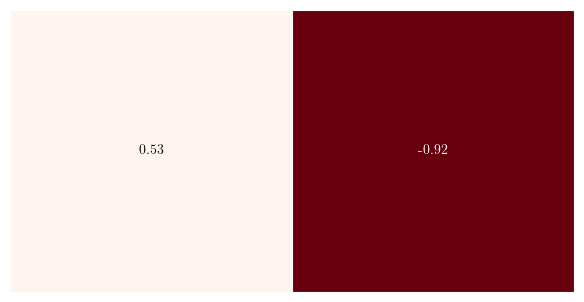

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# --- Configuration for ACL-style appearance ---
rcParams.update({
    "text.usetex": True,       # Use LaTeX for consistent fonts
    "font.family": "serif",    # Matches ACL paper font
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
})

# Slice first 10x10
data = np.array(data)
subset = data[:8, :16]

# --- Create figure ---
fig, ax = plt.subplots(figsize=(6, 4))  # compact square figure

cmap = plt.cm.Reds_r
im = ax.imshow(subset, cmap=cmap, interpolation='none', aspect='equal')

# Add subtle borders
for i in range(subset.shape[0] + 1):
    ax.axhline(i - 0.5, color='white', linewidth=0.8)
for j in range(subset.shape[1] + 1):
    ax.axvline(j - 0.5, color='white', linewidth=0.8)

# Annotations with automatic contrast
for i in range(subset.shape[0]):
    for j in range(subset.shape[1]):
        color = 'white' if subset[i, j] < 0.5 else 'black'
        ax.text(j, i, f"{subset[i, j]:.2f}", ha='center', va='center', color=color, fontsize=10)

# Remove axes for minimal look
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

plt.tight_layout()
# --- Save as vector PDF for ACL submission ---
plt.savefig("heatmap_acl_style.pdf", bbox_inches='tight')
plt.show()


# COHERENCE

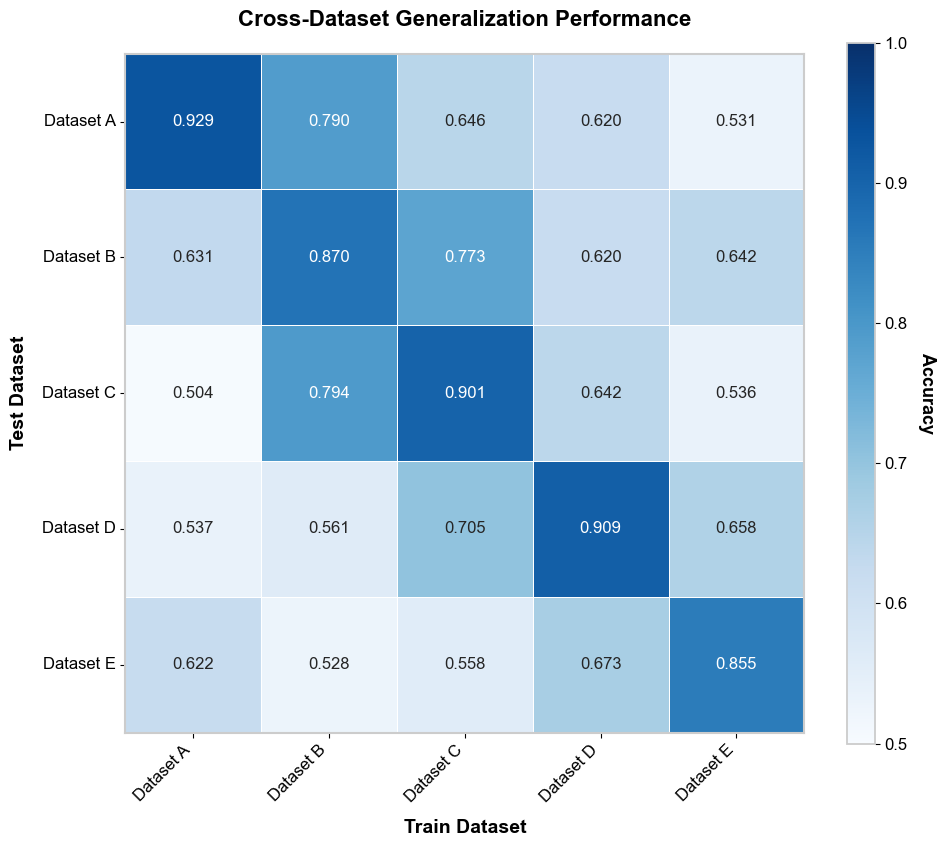

In [236]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_cross_dataset_heatmap(data, x_labels, y_labels, 
                               figsize=(10, 10), cmap='Blues',
                               title='Cross-Dataset Performance',
                               xlabel='Train Dataset', ylabel='Test Dataset',
                               annot=True, fmt='.2f', vmin=None, vmax=None,
                               cbar_label='Accuracy', font_size=12, shrink=0.75,
                               save_path=None, dpi=300):
    """
    Creates publication-ready cross-dataset heatmap.
    
    Args:
        data (array): 2D array of values (test datasets × train datasets)
        x_labels (list): Labels for x-axis (train datasets)
        y_labels (list): Labels for y-axis (test datasets)
        figsize (tuple): Figure size
        cmap (str): Colormap ('Blues', 'Greens', 'Reds', 'YlOrRd', 'viridis', etc.)
        title (str): Plot title
        xlabel (str): X-axis label
        ylabel (str): Y-axis label
        annot (bool): Whether to annotate cells with values
        fmt (str): Format string for annotations
        vmin (float): Minimum value for colormap
        vmax (float): Maximum value for colormap
        cbar_label (str): Colorbar label
        font_size (int): Base font size
        save_path (str): Path to save figure
        dpi (int): Resolution for saved figure
    """
    
    # Set publication style
    plt.rcParams.update({
        'font.size': font_size,
        'axes.labelsize': font_size + 2,
        'axes.titlesize': font_size + 4,
        'xtick.labelsize': font_size,
        'ytick.labelsize': font_size,
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'DejaVu Sans'],
    })
    
    fig, ax = plt.subplots(figsize=figsize, dpi=100)
    
    # Create heatmap
    sns.heatmap(data, 
                annot=annot, 
                fmt=fmt,
                cmap=cmap,
                xticklabels=x_labels, 
                yticklabels=y_labels,
                square=True, 
                ax=ax,
                vmin=vmin,
                vmax=vmax,
                cbar_kws={
                    'shrink': shrink,
                    'aspect': 25,
                    'pad': 0.05,
                    'label': cbar_label
                },
                linewidths=0.5,
                linecolor='white',
                annot_kws={'size': font_size})
    
    # Customize colorbar
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=font_size)
    cbar.set_label(cbar_label, fontsize=font_size + 1, 
                   fontweight='600', rotation=270, labelpad=20)
    cbar.outline.set_linewidth(1.3)
    cbar.outline.set_edgecolor('#CCCCCC')
    
    # Rotate and style tick labels
    plt.xticks(rotation=45, ha='right', fontsize=font_size)
    plt.yticks(rotation=0, fontsize=font_size)
    
    # Axis labels
    ax.set_xlabel(xlabel, fontsize=font_size + 2, fontweight='600', labelpad=10)
    ax.set_ylabel(ylabel, fontsize=font_size + 2, fontweight='600', labelpad=10)
    
    # Title
    ax.set_title(title, fontsize=font_size + 4, fontweight='600', pad=20)
    
    # Style borders
    for spine in ax.spines.values():
        spine.set_edgecolor('#CCCCCC')
        spine.set_linewidth(1.5)
        spine.set_visible(True)
    
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
        print(f"Figure saved to: {save_path}")
    
    plt.show()
    
    # Reset defaults
    plt.rcParams.update(plt.rcParamsDefault)


# Example usage
if __name__ == "__main__":
    np.random.seed(42)
    
    # Example datasets
    datasets = ['Dataset A', 'Dataset B', 'Dataset C', 'Dataset D', 'Dataset E']
    
    # Create example cross-dataset performance matrix
    # Diagonal should be highest (same train/test)
    n = len(datasets)
    data_sweep = np.random.uniform(0.5, 0.7, (n, n))
    
    # Make diagonal values higher (same dataset performance)
    for i in range(n):
        data_sweep[i, i] = np.random.uniform(0.85, 0.95)
    
    # Add some structure (nearby datasets perform better)
    for i in range(n):
        for j in range(n):
            distance = abs(i - j)
            if distance == 1:
                data_sweep[i, j] += 0.1
    
    # Create the plot
    plot_cross_dataset_heatmap(
        data=data_sweep,
        x_labels=datasets,
        y_labels=datasets,
        figsize=(10, 10),
        cmap='Blues',  # Options: 'Blues', 'Greens', 'YlOrRd', 'viridis', 'RdYlBu_r'
        title='Cross-Dataset Generalization Performance',
        xlabel='Train Dataset',
        ylabel='Test Dataset',
        annot=True,
        fmt='.3f',  # 3 decimal places
        vmin=0.5,
        vmax=1.0,
        cbar_label='Accuracy',
        font_size=12,
        # save_path='cross_dataset_heatmap.pdf'  # Uncomment to save
    )

In [34]:
# Each path is different because I was messy

model = 'llama'
llama_data_dict = t.load(PATH / model / 'COHERENCE' / f"coherence_scoresnegorand_logits_logistic_regression_mmp_self_report")

model = 'llama_instruct'
llama_instruct_data_dict_1 = t.load(PATH / model / 'COHERENCE' / f"coherence_scoresnegorand_logits_logistic_regression_mmp")
llama_instruct_data_dict_2 = t.load(PATH / model / 'COHERENCE' / f"coherence_scoresnegorand_self_report")
llama_instruct_data_dict = {**llama_instruct_data_dict_1, **llama_instruct_data_dict_2}

model = 'gpt-j'
gpt_j_data_dict_1 = t.load(PATH / model / 'COHERENCE' / f"coherence_scoresnegorand_logits_logistic_regression_mmp")
gpt_j_data_dict_2 = t.load(PATH / model / 'COHERENCE' / f"coherence_scoresnegorand_self_report")
gpt_j_data_dict = {**gpt_j_data_dict_1, **gpt_j_data_dict_2}

model = 'gemma'
gemma_data_dict_1 = t.load(PATH / model / 'COHERENCE' / f"coherence_scoresnegorand_logistic_regression_mmp_logits")
gemma_data_dict_2 = t.load(PATH / model / 'COHERENCE' / f"coherence_scoresnegorand_self_report")
gemma_data_dict = {**gemma_data_dict_1, **gemma_data_dict_2}

model = 'gemma_instruct'
gemma_instruct_data_dict_1 = t.load(PATH / model / 'COHERENCE' / f"coherence_scoresnegorand_logits_logistic_regression_mmp")
gemma_instruct_data_dict_2 = t.load(PATH / model / 'COHERENCE' / f"coherence_scoresnegorand_self_report")
gemma_instruct_data_dict = {**gemma_instruct_data_dict_1, **gemma_instruct_data_dict_2}



In [35]:
from collections import OrderedDict

key_order = ['logistic_regression', 'mmp', 'self_report', 'logits']

def make_ordered_custom(d, order):
    """
    Recursively convert nested dicts into OrderedDicts
    following a custom key order.
    """
    if isinstance(d, dict):
        od = OrderedDict()
        for k in order:
            if k in d:
                od[k] = make_ordered_custom(d[k], order)
        # Add any keys not in the custom order at the end
        for k in d:
            if k not in order:
                od[k] = make_ordered_custom(d[k], order)
        return od
    elif isinstance(d, (list, tuple)):
        return type(d)(make_ordered_custom(x, order) if isinstance(x, dict) else x for x in d)
    else:
        return d

# Example: convert your data
dicts = [llama_data_dict, llama_instruct_data_dict, gpt_j_data_dict, gemma_data_dict, gemma_instruct_data_dict]
data_ordered = [make_ordered_custom(d, key_order) for d in dicts]

In [276]:


def plot_grouped_bars_multi(data_list, model_names, tests=['neg', 'or', 'and'], 
                           probe_methods=['logistic_regression', 'mmp', 'self_report', 'logits'],
                           figsize=(16, 10), 
                           ylabel='Score', suptitle='Probe Method Comparison Across Models',
                           ncols=3):
    """
    Creates multiple grouped bar plots in a grid layout for comparing models.
    
    Args:
        data_list (list): List of data dictionaries, one per model
        model_names (list): List of model names corresponding to data_list
        tests (list): List of test names
        probe_methods (list): List of probe method names (order for bars)
        figsize (tuple): Figure size
        ylabel (str): Y-axis label
        suptitle (str): Overall figure title
        ncols (int): Number of columns in subplot grid
    """
    
    n_models = len(data_list)
    nrows = (n_models + ncols - 1) // ncols  # Ceiling division
    
    # Define colors for each probe method
    colors = ['#0173B2', '#DE8F05', '#029E73', '#CC3311']  # Blue, Orange, Green, Red
    
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, sharey=True)
    
    # Flatten axes for easier iteration
    if n_models == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if nrows > 1 else [axes] if ncols == 1 else axes
    
    for model_idx, (data, model_name) in enumerate(zip(data_list, model_names)):
        ax = axes[model_idx]
        
        n_probes = len(probe_methods)
        n_tests = len(tests)
        
        # Set up bar positions
        x = np.arange(n_tests)
        bar_width = 0.8 / n_probes
        
        # Plot bars for each probe method
        for i, probe in enumerate(probe_methods):
            if probe not in data:
                continue
                
            metrics = [data[probe][test][0] for test in tests]
            baselines = [data[probe][test][1] for test in tests]
            
            offset = (i - n_probes/2 + 0.5) * bar_width
            
            # Plot baseline bars (behind)
            ax.bar(x + offset, baselines, bar_width, 
                   color='white', 
                   edgecolor='black', 
                   linewidth=1.0,
                   hatch='//',
                   alpha=0.8)
            
            # Plot metric bars (on top)
            ax.bar(x + offset, metrics, bar_width,
                   color=colors[i % len(colors)],
                   alpha=0.6)
        
        # Customize subplot
        ax.set_title(model_name.replace('_', ' ').title(), fontsize=12, fontweight='600', pad=10)
        ax.set_xticks(x)
        ax.set_xticklabels([test.upper() for test in tests], fontsize=10)
        ax.set_ylim(0.3, 1.0)
        # Major ticks every 0.1
        ax.set_yticks(np.arange(0, 1, 0.1))

        # Minor ticks every 0.05
        ax.set_yticks(np.arange(0, 1, 0.05), minor=True)
        ax.grid(True, alpha=0.3, axis='y', linestyle='--')
        ax.set_axisbelow(True)
        
        # Y-label only on leftmost column
        if model_idx % ncols == 0:
            ax.set_ylabel(ylabel, fontsize=11, fontweight='600')
        
        # Style borders
        for spine in ax.spines.values():
            spine.set_edgecolor('#CCCCCC')
            spine.set_linewidth(1.2)
    
    # Hide unused subplots
    for idx in range(n_models, len(axes)):
        axes[idx].set_visible(False)
    
    # Add overall title
    fig.suptitle(suptitle, fontsize=15, fontweight='600', y=0.98)
    
    # Create custom legend with both metrics and baseline
    legend_handles = []
    
    # Add probe method handles (colored bars)
    for i, probe in enumerate(probe_methods):
        legend_handles.append(
            mpatches.Patch(color=colors[i % len(colors)], alpha=0.6,
                          label=probe.replace('_', ' ').title())
        )
    
    # Add baseline handle (hatched white bar)
    legend_handles.append(
        mpatches.Patch(facecolor='white', edgecolor='black', 
                      hatch='//', label='Baseline')
    )
    
    fig.legend(handles=legend_handles, loc='upper center', 
              bbox_to_anchor=(0.5, 0.95),
              ncol=len(probe_methods) + 1, framealpha=0.95, fontsize=10,
              edgecolor='#CCCCCC', fancybox=False)
    
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

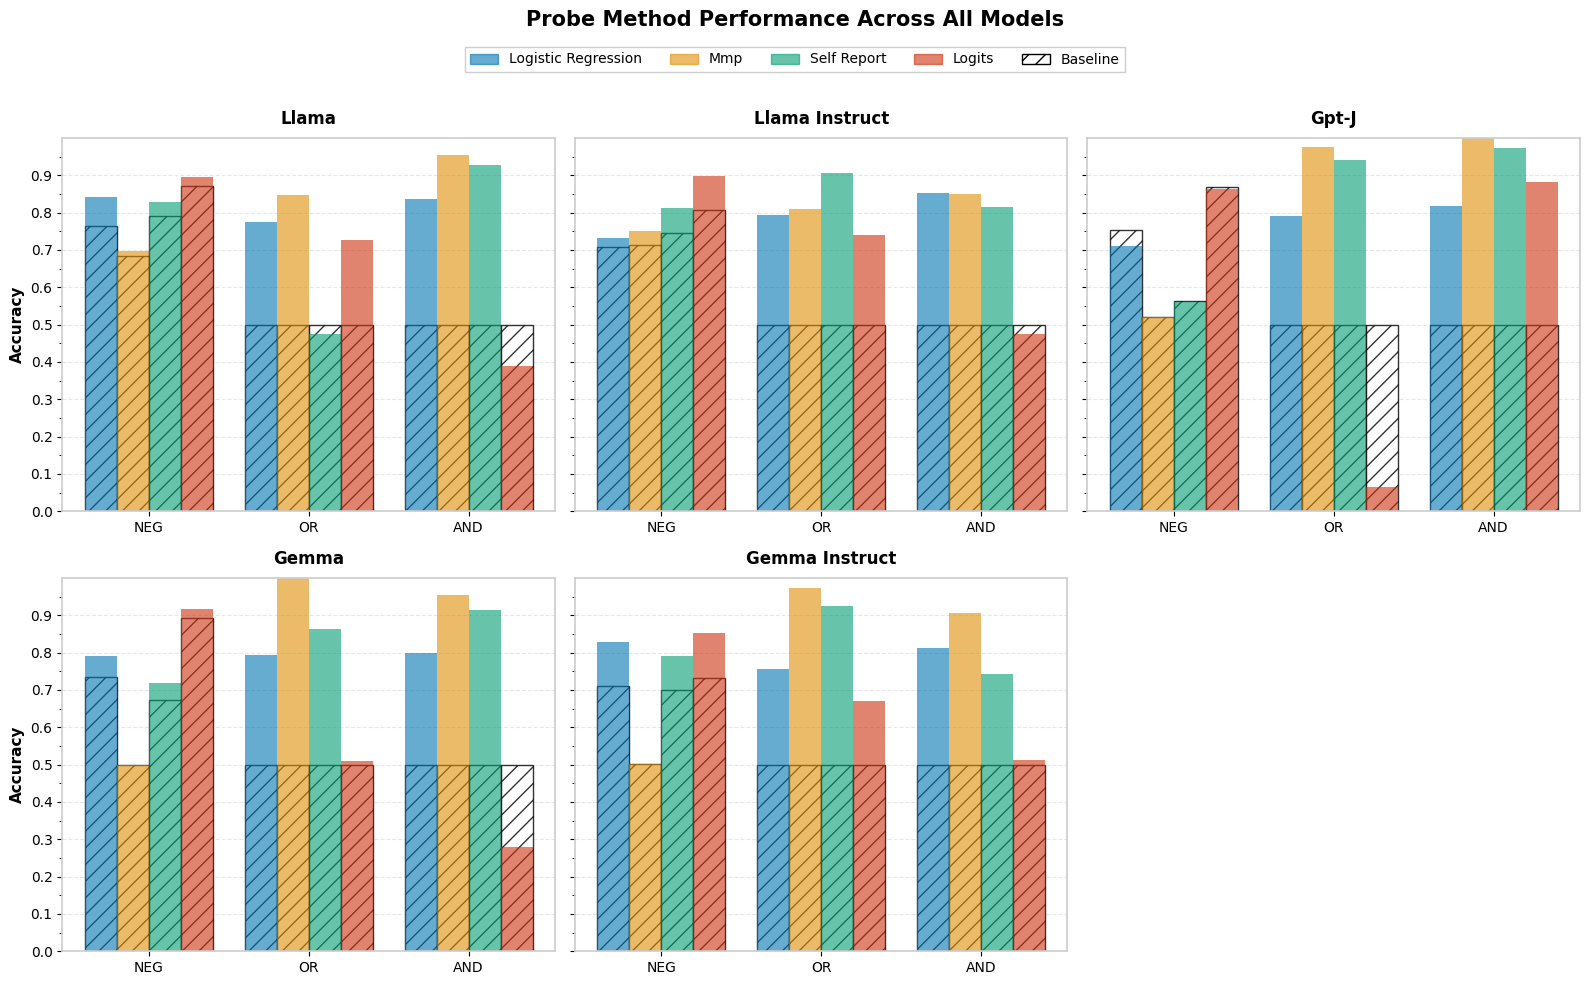

In [277]:
order = ['llama', 'llama_instruct', 'gpt-j', 'gemma', 'gemma_instruct']
probe_methods = ['logistic_regression', 'mmp', 'self_report', 'logits']
tests = ['neg', 'or', 'and']


plot_grouped_bars_multi(
        data_list=data_ordered,
        model_names=order,
        tests=tests,
        probe_methods=probe_methods,
        figsize=(16, 10),
        ylabel='Accuracy',
        suptitle='Probe Method Performance Across All Models',
        ncols=3  # 3 columns, 2 rows for 5 models
    )

# UNIFORMITY

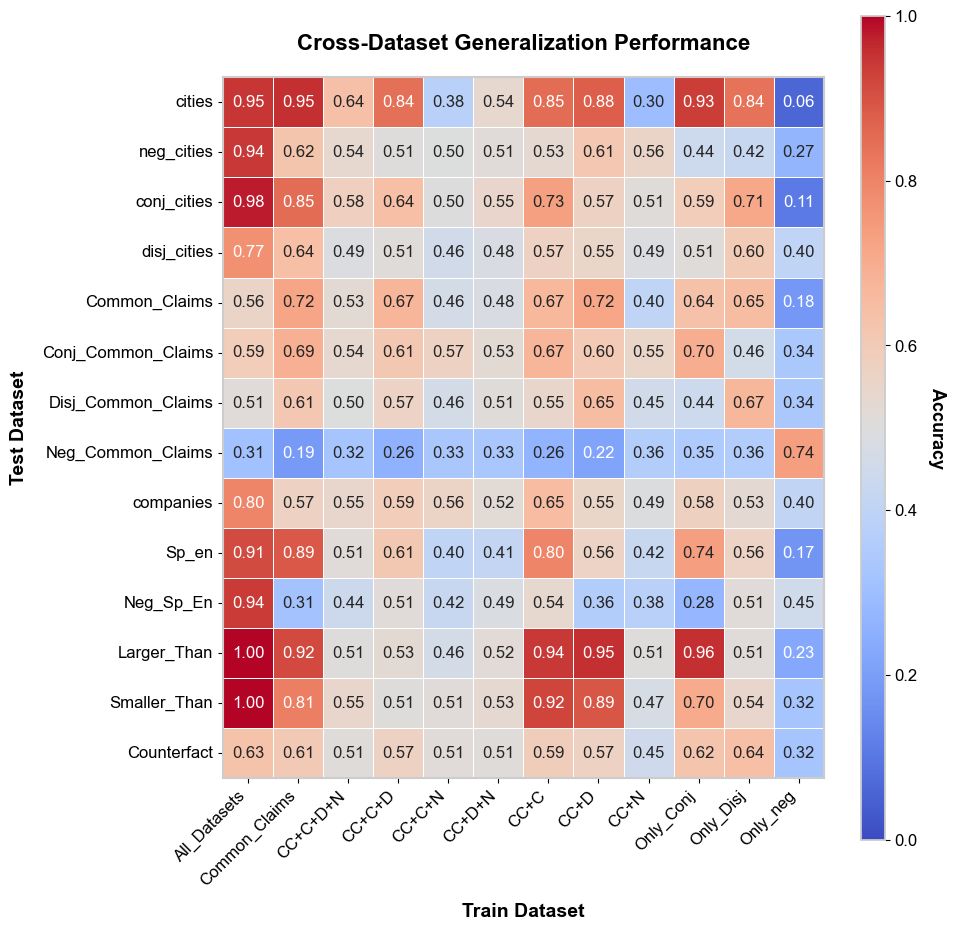

In [229]:
model = 'llama_instruct'
UNIF_TYPE = 'logic'

if UNIF_TYPE == 'domain':
    x_ticks = ['All_Datasets', 'Common_Claims', 'CC+Cities', 'cities', 'CC+Companies', 'companies', 'CC+Sp_en', 'Sp_en', 'CC+Larger_Than', 'Larger_than', 'CC+Counterfact', 'Counterfact']
    y_ticks = ['cities', 'Common_Claims', 'companies', 'Sp_En', 'Larger_Than', 'Counterfact']

elif UNIF_TYPE == 'logic':
    x_ticks = ['All_Datasets', 'Common_Claims', 'CC+C+D+N', 'CC+C+D', 'CC+C+N', 'CC+D+N', 'CC+C', 'CC+D', 'CC+N', 'Only_Conj', 'Only_Disj', 'Only_neg']
    y_ticks = ['cities', 'neg_cities', 'conj_cities', 'disj_cities', 'Common_Claims', 'Conj_Common_Claims', 'Disj_Common_Claims', 'Neg_Common_Claims', 'companies', 'Sp_en', 'Neg_Sp_En', 'Larger_Than', 'Smaller_Than', 'Counterfact']

else:
    raise ValueError("You messed up. Have an error")

# Your data loading code remains the same
data_sweep = t.load(PATH / model / 'UNIFORMITY' / f"uniformity_uniformity{UNIF_TYPE}")
data_sweep = np.array([[data_sweep[row][col][0] for col in sorted(data_sweep[row])] for row in sorted(data_sweep)]).T

n_rows, n_cols = data_sweep.shape

plot_cross_dataset_heatmap(
        data=data_sweep,
        x_labels=x_ticks,
        y_labels=y_ticks,
        figsize=(10, 10),
        cmap='coolwarm',  # Options: 'Blues', 'Greens', 'YlOrRd', 'viridis', 'RdYlBu_r'
        title='Cross-Dataset Generalization Performance',
        xlabel='Train Dataset',
        ylabel='Test Dataset',
        annot=True,
        fmt='.2f',  # 3 decimal places
        vmin=0,
        vmax=1.0,
        cbar_label='Accuracy',
        font_size=12,
        # save_path='cross_dataset_heatmap.pdf'  # Uncomment to save
    )

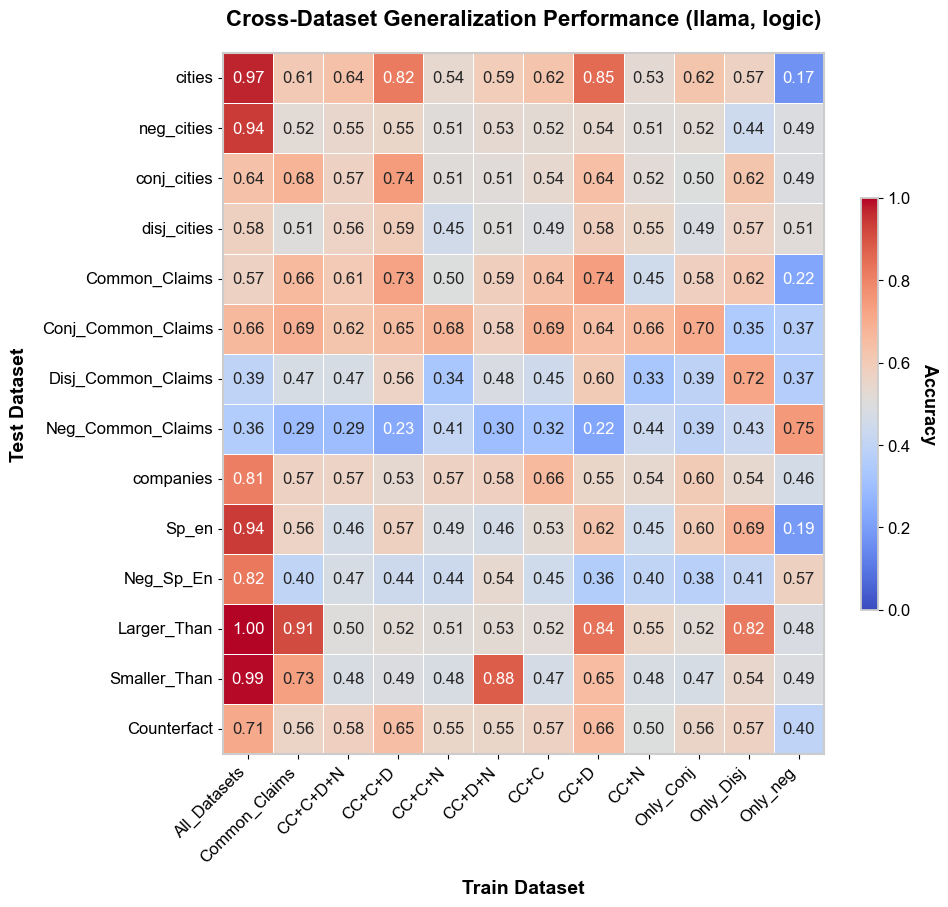

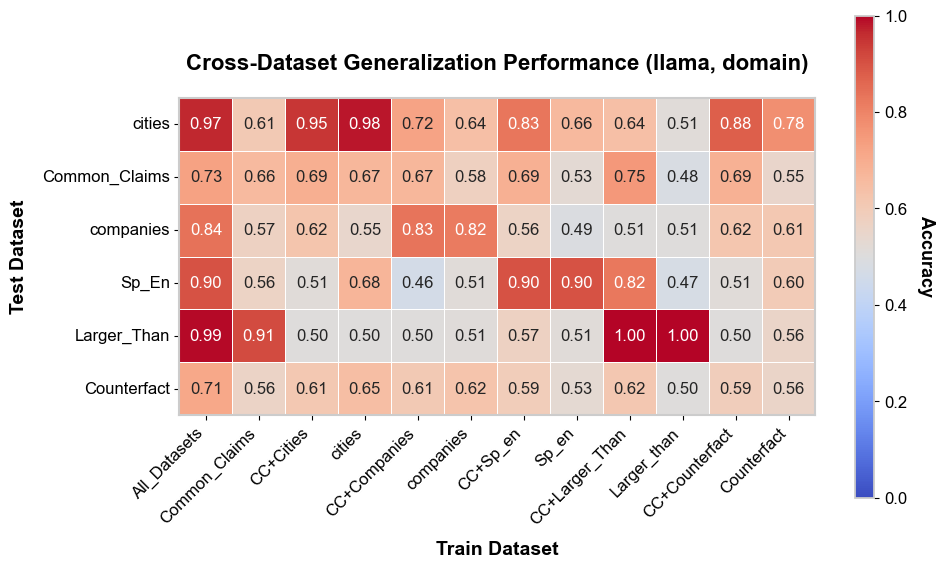

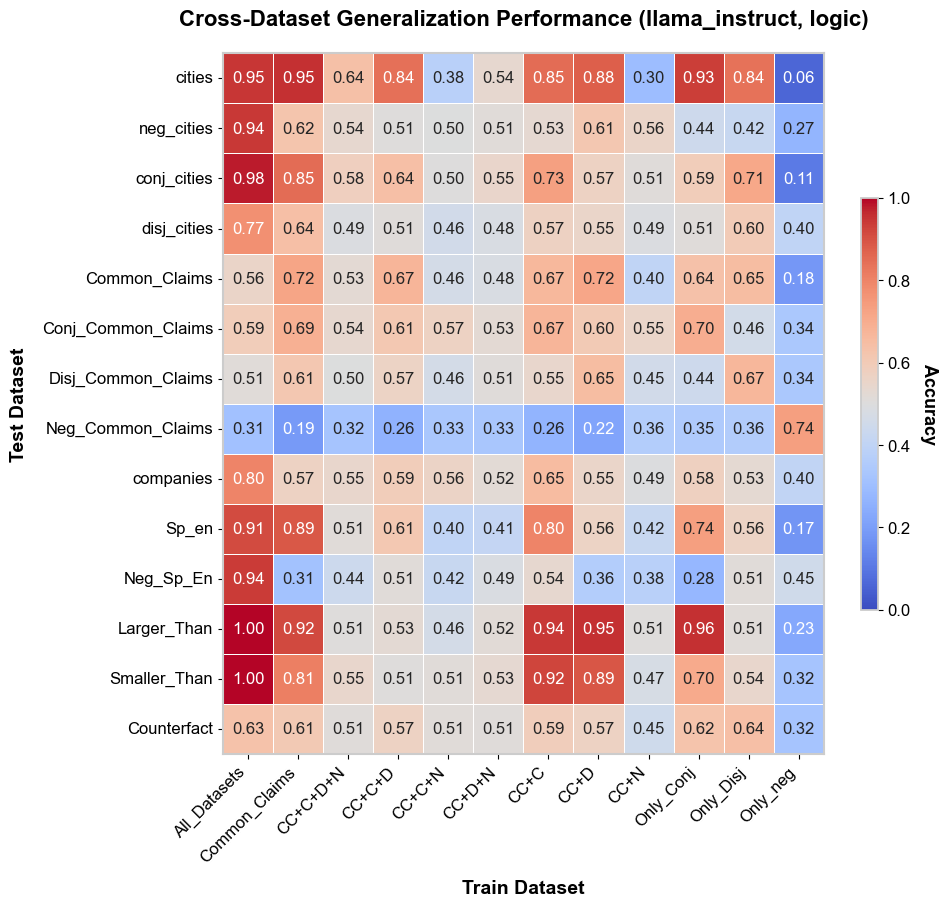

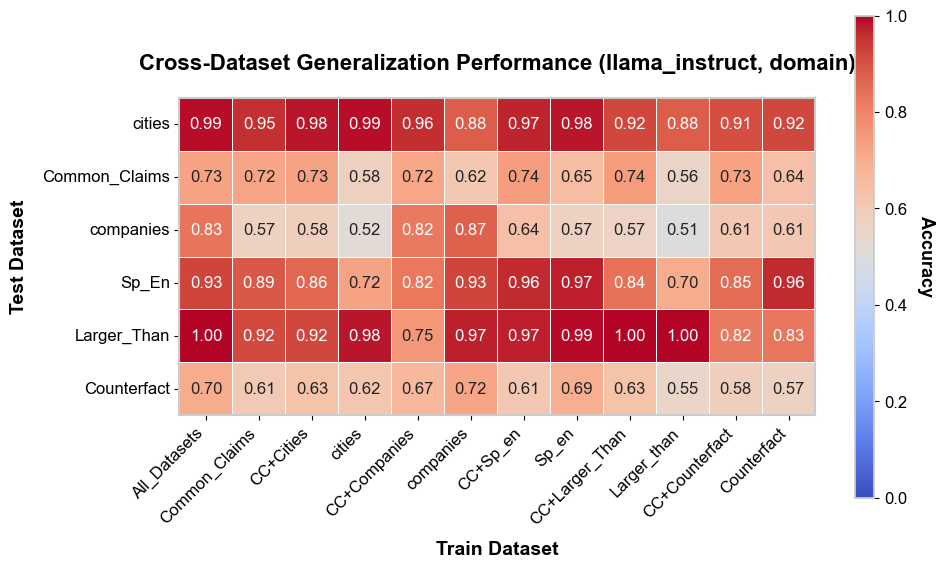

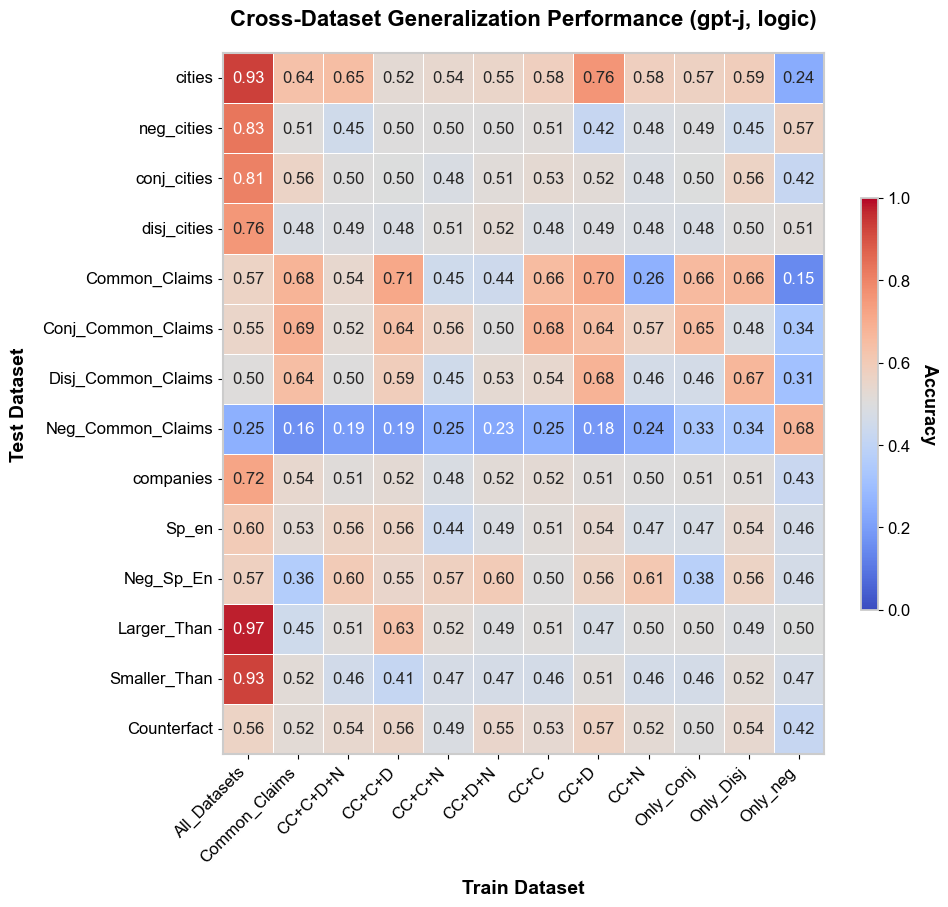

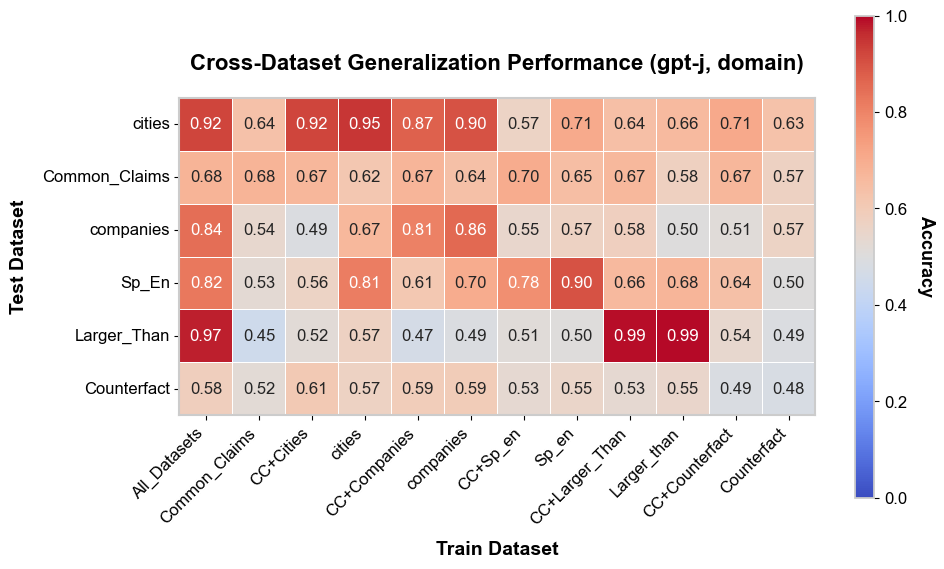

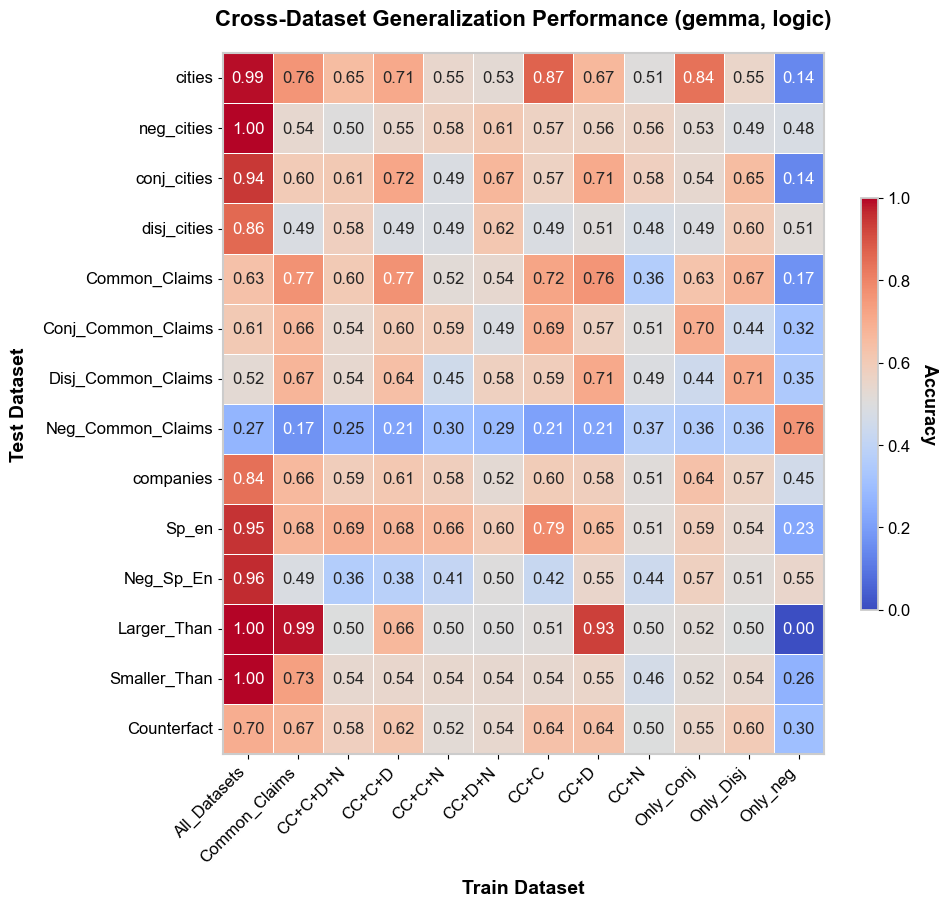

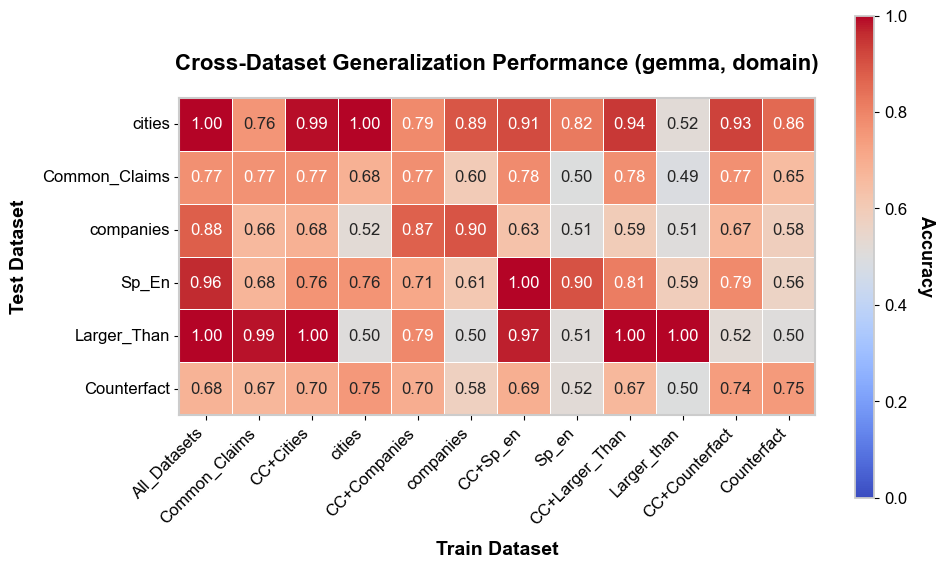

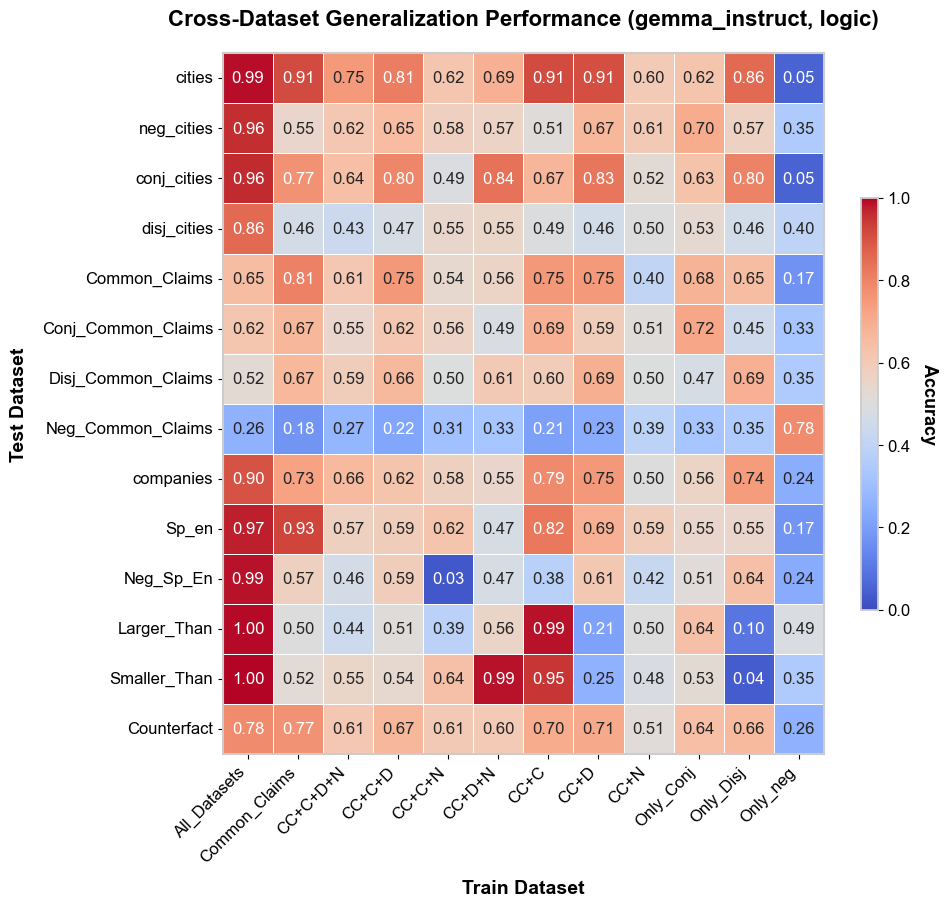

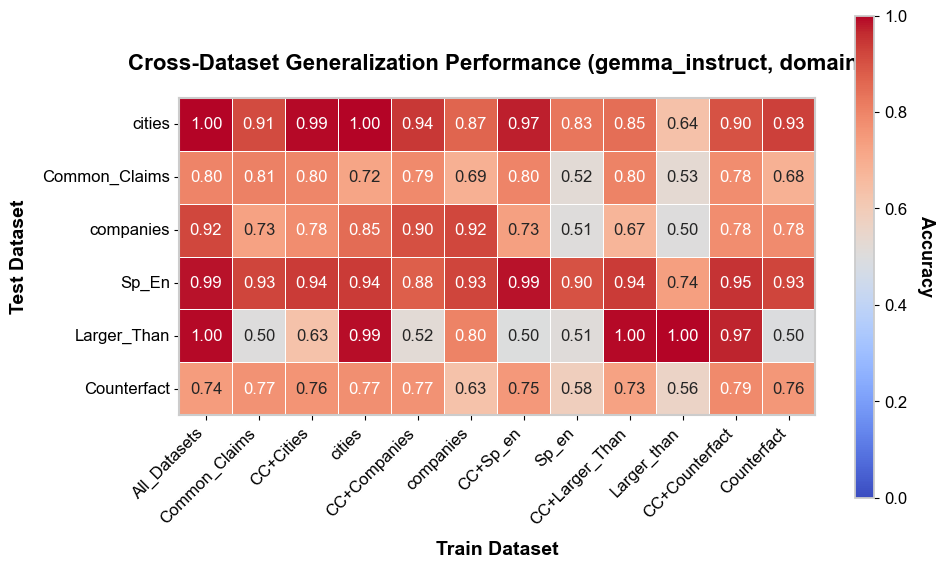

In [237]:
import torch as t
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

PATH = Path("results_to_plot")

models = ['llama', 'llama_instruct', 'gpt-j', 'gemma', 'gemma_instruct']
unif_types = ['logic', 'domain']

# Container for all matrices
matrices = {}

for model in models:
    matrices[model] = {}
    for UNIF_TYPE in unif_types:
        # Set x_ticks and y_ticks per UNIF_TYPE
        if UNIF_TYPE == 'domain':
            x_ticks = ['All_Datasets', 'Common_Claims', 'CC+Cities', 'cities', 'CC+Companies', 'companies', 
                       'CC+Sp_en', 'Sp_en', 'CC+Larger_Than', 'Larger_than', 'CC+Counterfact', 'Counterfact']
            y_ticks = ['cities', 'Common_Claims', 'companies', 'Sp_En', 'Larger_Than', 'Counterfact']

        elif UNIF_TYPE == 'logic':
            x_ticks = ['All_Datasets', 'Common_Claims', 'CC+C+D+N', 'CC+C+D', 'CC+C+N', 'CC+D+N', 
                       'CC+C', 'CC+D', 'CC+N', 'Only_Conj', 'Only_Disj', 'Only_neg']
            y_ticks = ['cities', 'neg_cities', 'conj_cities', 'disj_cities', 'Common_Claims', 'Conj_Common_Claims',
                       'Disj_Common_Claims', 'Neg_Common_Claims', 'companies', 'Sp_en', 'Neg_Sp_En', 
                       'Larger_Than', 'Smaller_Than', 'Counterfact']
        else:
            raise ValueError("UNIF_TYPE not recognized")

        # Load the data
        data_sweep = t.load(PATH / model / 'UNIFORMITY' / f"uniformity_uniformity{UNIF_TYPE}")
        data_array = np.array([[data_sweep[row][col][0] for col in sorted(data_sweep[row])] 
                               for row in sorted(data_sweep)]).T

        # Store the full matrix
        matrices[model][UNIF_TYPE] = data_array

        plot_cross_dataset_heatmap(
        data=data_array,
        x_labels=x_ticks,
        y_labels=y_ticks,
        figsize=(10, 10),
        cmap='coolwarm',  # Options: 'Blues', 'Greens', 'YlOrRd', 'viridis', 'RdYlBu_r'
        title=f'Cross-Dataset Generalization Performance ({model}, {UNIF_TYPE})',
        xlabel='Train Dataset',
        ylabel='Test Dataset',
        annot=True,
        fmt='.2f',  # 3 decimal places
        shrink=0.5,
        vmin=0,
        vmax=1.0,
        cbar_label='Accuracy',
        font_size=12,
        # save_path='cross_dataset_heatmap.pdf'  # Uncomment to save
    )

# 'matrices' now contains all 10 full matrices
# Access example: matrices['llama_instruct']['logic']


In [39]:
matrices_logic = {model: matrices[model]['logic'] for model in models}
matrices_domain = {model: matrices[model]['domain'] for model in models}

# FINAL SCORES

## ACCURACY

llama: 0.903
llama_instruct: 0.883
gemma: 0.922
gemma_instruct: 0.925
gpt-j: 0.804
pythia: 0.761
pythia_deduped: 0.685
yi: 0.598
yi_instruct: 0.727
gpt: 0.570
llama_medium: 0.901
baseline: 0.500

llama: 0.864
llama_instruct: 0.903
gemma: 0.916
gemma_instruct: 0.931
gpt-j: 0.726
pythia: 0.675
pythia_deduped: 0.675
yi: 0.638
yi_instruct: 0.733
gpt: 0.563
llama_medium: 0.857
baseline: 0.500


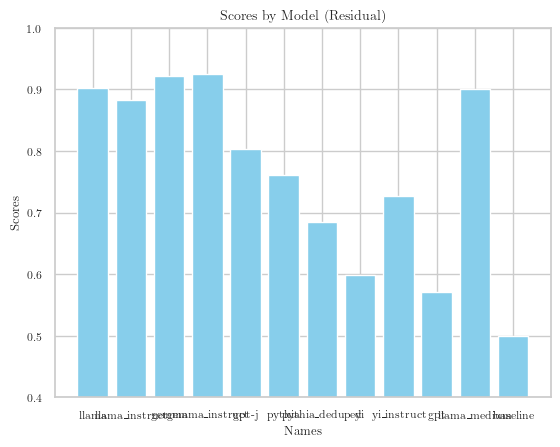

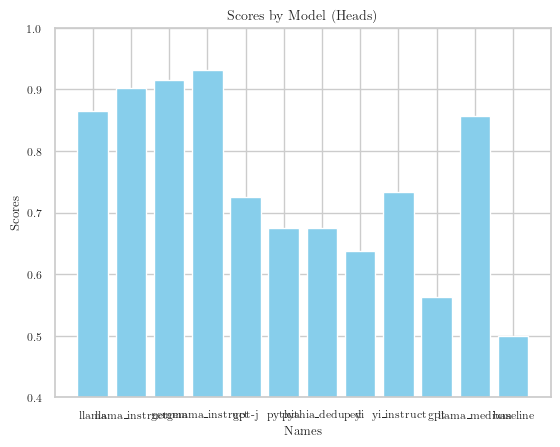

In [40]:
def score_accuracy(data, top_k=None):
    
    data = t.tensor(data) if not isinstance(data, t.Tensor) else data
    if top_k is not None:
        # Flatten to 1D and select top-k
        top_values = t.topk(data.flatten(), top_k).values
        score = top_values.mean().item()
    else:
        score = data.mean().item()
    return score

top_k = 1
model = 'llama'
heads = t.load(PATH / model / 'ACCURACY' / 'accuracies_heads')
residual = t.load(PATH / model / 'ACCURACY' / 'accuracies_residual')
llama_score_r = score_accuracy(residual, top_k=top_k)
llama_score_h = score_accuracy(heads, top_k=top_k)
model = 'llama_instruct'
heads = t.load(PATH / model / 'ACCURACY' / 'accuracies_heads')
residual = t.load(PATH / model / 'ACCURACY' / 'accuracies_residual')
llama_instruct_score_r = score_accuracy(residual, top_k=top_k)
llama_instruct_score_h = score_accuracy(heads, top_k=top_k)
model = 'gemma'
heads = t.load(PATH / model / 'ACCURACY' / 'accuracies_heads')
residual = t.load(PATH / model / 'ACCURACY' / 'accuracies_residual')
gemma_score_r = score_accuracy(residual, top_k=top_k)
gemma_score_h = score_accuracy(heads, top_k=top_k)
model = 'gemma_instruct'
heads = t.load(PATH / model / 'ACCURACY' / 'accuracies_heads')
residual = t.load(PATH / model / 'ACCURACY' / 'accuracies_residual')
gemma_instruct_score_r = score_accuracy(residual, top_k=top_k)
gemma_instruct_score_h = score_accuracy(heads, top_k=top_k)
model = 'gpt-j'
heads = t.load(PATH / model / 'ACCURACY' / 'accuracies_heads')
residual = t.load(PATH / model / 'ACCURACY' / 'accuracies_residual')
gpt_j_score_r = score_accuracy(residual, top_k=top_k)
gpt_j_score_h = score_accuracy(heads, top_k=top_k)
model = 'pythia'
heads = t.load(PATH / model / 'ACCURACY' / 'accuracies_heads')
residual = t.load(PATH / model / 'ACCURACY' / 'accuracies_residual')
pythia_score_r = score_accuracy(residual, top_k=top_k)
pythia_score_h = score_accuracy(heads, top_k=top_k)
model = 'pythia_instruct'
heads = t.load(PATH / model / 'ACCURACY' / 'accuracies_heads')
residual = t.load(PATH / model / 'ACCURACY' / 'accuracies_residual')
pythia_instruct_score_r = score_accuracy(residual, top_k=top_k)
pythia_instruct_score_h = score_accuracy(heads, top_k=top_k)
model = 'yi'
heads = t.load(PATH / model / 'ACCURACY' / 'accuracies_heads')
residual = t.load(PATH / model / 'ACCURACY' / 'accuracies_residual')
yi_score_r = score_accuracy(residual, top_k=top_k)
yi_score_h = score_accuracy(heads, top_k=top_k)
model = 'yi_instruct'
heads = t.load(PATH / model / 'ACCURACY' / 'accuracies_heads')
residual = t.load(PATH / model / 'ACCURACY' / 'accuracies_residual')
yi_instruct_score_r = score_accuracy(residual, top_k=top_k)
yi_instruct_score_h = score_accuracy(heads, top_k=top_k)
model = 'gpt'
heads = t.load(PATH / model / 'ACCURACY' / 'accuracies_heads')
residual = t.load(PATH / model / 'ACCURACY' / 'accuracies_residual')
gpt_score_r = score_accuracy(residual, top_k=top_k)
gpt_score_h = score_accuracy(heads, top_k=top_k)
model = 'llama_medium'
heads = t.load(PATH / model / 'ACCURACY' / 'accuracies_heads')
residual = t.load(PATH / model / 'ACCURACY' / 'accuracies_residual')
llama_medium_score_r = score_accuracy(residual, top_k=top_k)
llama_medium_score_h = score_accuracy(heads, top_k=top_k)

results_accuracy_residual = {
    'llama': llama_score_r,
    'llama_instruct': llama_instruct_score_r,
    'gemma': gemma_score_r,
    'gemma_instruct': gemma_instruct_score_r,
    'gpt-j': gpt_j_score_r,
    'pythia': pythia_score_r,
    'pythia_deduped': pythia_instruct_score_r,
    'yi': yi_score_r,
    'yi_instruct': yi_instruct_score_r,
    'gpt': gpt_score_r,
    'llama_medium': llama_medium_score_r,
    'baseline': 0.5
}

results_accuracy_heads = {
    'llama': llama_score_h,
    'llama_instruct': llama_instruct_score_h,
    'gemma': gemma_score_h,
    'gemma_instruct': gemma_instruct_score_h,
    'gpt-j': gpt_j_score_h,
    'pythia': pythia_score_h,
    'pythia_deduped': pythia_score_h,
    'yi': yi_score_h,
    'yi_instruct': yi_instruct_score_h,
    'gpt': gpt_score_h,
    'llama_medium': llama_medium_score_h,
    'baseline': 0.5
}    

for name, score in results_accuracy_residual.items():
    print(f"{name}: {score:.3f}")
print()
for name, score in results_accuracy_heads.items():
    print(f"{name}: {score:.3f}")

plt.bar(results_accuracy_residual.keys(), results_accuracy_residual.values(), color='skyblue')
plt.xlabel('Names')
plt.ylabel('Scores')
plt.title('Scores by Model (Residual)')
plt.ylim(0.4, 1)
plt.show()
plt.bar(results_accuracy_heads.keys(), results_accuracy_heads.values(), color='skyblue')
plt.xlabel('Names')
plt.ylabel('Scores')
plt.title('Scores by Model (Heads)')
plt.ylim(0.4, 1)
plt.show()

## INTERVENTION

In [41]:
# Should take in data as (N(Correct), N(Flipped), Strength, k, alpha...)

def score_intervention(data):
    
    success = data[1] - data[0]     # Flipped answers
    strength = data[2]              # Alpha * K / d_model

    relative_success = success / strength if strength != 0 else 0

    return 1 / (1 + relative_success)

## UNIFORMITY

In [280]:
# Takes in a cross-domain/cross-logic matrix

def score_uniformity(matrix):
    matrix = np.array(matrix)
    
    # Overall score
    overall_score = np.mean(matrix) - np.std(matrix)
    
    # First column score
    first_col = matrix[:, 0]
    first_col_score = np.mean(first_col) - np.std(first_col)
    
    return overall_score, first_col_score


In [281]:
llama_unif = score_uniformity(matrices_domain['llama']) 
llama_instruct_unif = score_uniformity(matrices_domain['llama_instruct'])
gpt_j_unif = score_uniformity(matrices_domain['gpt-j'])
gemma_unif = score_uniformity(matrices_domain['gemma'])
gemma_instruct_unif = score_uniformity(matrices_domain['gemma_instruct'])

domain_scores = {
    "llama": llama_unif,
    "llama_instruct": llama_instruct_unif,
    "gpt_j": gpt_j_unif,
    "gemma": gemma_unif,
    "gemma_instruct": gemma_instruct_unif
}

for model, score in domain_scores.items():
    print(model, "\ngeneral", score[0], "all_datasets", score[1])

llama 
general 0.5060460867301433 all_datasets 0.747667177367418
llama_instruct 
general 0.6273841045124473 all_datasets 0.7440517758617988
gpt_j 
general 0.5057649197070717 all_datasets 0.6697445155165004
gemma 
general 0.5757640961829853 all_datasets 0.7630370675660534
gemma_instruct 
general 0.6414518582301165 all_datasets 0.8071401826715009


## COHERENCE

In [44]:
# Takes in a cross-logic matrix

llama_coherence_1 = score_uniformity(matrices_logic['llama']) 
llama_instruct_coherence_1 = score_uniformity(matrices_logic['llama_instruct'])
gpt_j_coherence_1 = score_uniformity(matrices_logic['gpt-j'])
gemma_coherence_1 = score_uniformity(matrices_logic['gemma'])
gemma_instruct_coherence_1 = score_uniformity(matrices_logic['gemma_instruct'])

coherence_scores = {
    "llama": llama_coherence_1,
    "llama_instruct": llama_instruct_coherence_1,
    "gpt_j": gpt_j_coherence_1,
    "gemma": gemma_coherence_1,
    "gemma_instruct": gemma_instruct_coherence_1
}

for model, score in coherence_scores.items():
    print(model, "\ngeneral", score[0], "all_datasets", score[1])

llama 
general 0.4031002976693211 all_datasets 0.5318043842582401
llama_instruct 
general 0.36961754379750555 all_datasets 0.5648162507072334
gpt_j 
general 0.38601121711885966 all_datasets 0.4877322158634759
gemma 
general 0.3874629960165311 all_datasets 0.5869364175167491
gemma_instruct 
general 0.36699448959868824 all_datasets 0.6014197270555243


In [258]:
logreg_data = [x['logistic_regression'] for x in data_ordered]

# Pass in logistic_regression coherence scores. Everything will be shifted by 0.5 for readability

def score_coherence_2(data):

    diffs = [v[0]-v[1] for v in data.values()]
   
    return np.mean(diffs) + 0.5

model_scores_coherence_2 = []

for model in logreg_data:
    model_scores_coherence_2.append(score_coherence_2(model))

model_scores_coherence_2.append(0.5)
models = ['llama', 'llama_instruct', 'gpt-j', 'gemma', 'gemma_instruct', 'baselines']

for model, score in zip(models, model_scores_coherence_2):
    print(model, score-0.5)
    

llama 0.22924417400944108
llama_instruct 0.22282578737140224
gpt-j 0.1874627389526491
gemma 0.21658479639082429
gemma_instruct 0.2287662602402427
baselines 0.0


In [57]:
import plotly.graph_objects as go

benchmarks_residual = ['Accuracy', 'Use', 'Coherence 1', 'Coherence 2', 'Uniformity']
benchmarks_heads = ['Accuracy', 'Use', 'Coherence 1', 'Coherence 2', 'Uniformity']

model_scores_r = {
    'Llama': [0.88, 0.90, 0.531, 0.729, 0.747],
    'Llama-It': [0.92, 1, 0.7, 0.9, 0.6],
    'Gemma': [0.91, 0.94, 0.8, 0.7, 0.8],
    'Gemma-It': [0.93, 0.95, 0.82, 0.9, 0.5],
    'GPT-J': [0.60, 0.6, 0.5, 0.5, 0.55],
    'Baselines': [0.55, 0.5, 0.5, 0.5, 0.55]
}

model_scores_h = {
    'Llama': [0.88, 0.90, 0.531, 0.729, 0.747],
    'Llama-It': [0.92, 1, 0.7, 0.9, 0.6],
    'Gemma': [0.91, 0.94, 0.8, 0.7, 0.8],
    'Gemma-It': [0.93, 0.95, 0.82, 0.9, 0.5],
    'GPT-J': [0.60, 0.6, 0.5, 0.5, 0.55],
    'Baselines': [0.55, 0.5, 0.5, 0.5, 0.55]
}

# Define colors for main models
colors = {
    'Llama': '#2ca02c',      # blue
    'Gemma': '#9467bd',      # purple
    'GPT-J': '#ff7f0e',      # orange
    'Baselines': '#111111'   # black
}
# Residual Radar
fig_residual = go.Figure()
for model, scores in model_scores_r.items():
    # Set dash style
    dash_style = 'dash' if '-It' in model else 'solid'
    # Set color (instruct models take the same color as base model)
    base_model = model.replace('-It','')
    color = colors.get(base_model, 'gray')
    fig_residual.add_trace(go.Scatterpolar(
        r=scores + [scores[0]],
        theta=benchmarks_residual + [benchmarks_residual[0]],
        fill='none',
        name=model,
        line=dict(color=color, dash=dash_style, width=1.5)
    ))

fig_residual.update_layout(
    polar=dict(radialaxis=dict(range=[0, 1])),
    title="Residual Metrics Radar"
)
fig_residual.show()

# Heads Radar
fig_heads = go.Figure()
for model, scores in model_scores_h.items():
    dash_style = 'dash' if '-It' in model else 'solid'
    base_model = model.replace('-It','')
    color = colors.get(base_model, 'gray')
    fig_heads.add_trace(go.Scatterpolar(
        r=scores + [scores[0]],
        theta=benchmarks_heads + [benchmarks_heads[0]],
        fill='none',
        name=model,
        line=dict(color=color, dash=dash_style, width=1.5)
    ))

fig_heads.update_layout(
    polar=dict(radialaxis=dict(range=[0, 1])),
    title="Heads Metrics Radar"
)
fig_heads.show()

